In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

bitcoin_data = pd.read_csv('cryptocurrencypricehistory/bitcoin_dataset.csv', header = 0, parse_dates=['Date'])
bitcoin_data['Year'] = bitcoin_data['Date'].apply(lambda x: x.year)
bitcoin_data['Month'] = bitcoin_data['Date'].apply(lambda x: x.month)
bitcoin_data = bitcoin_data.loc[bitcoin_data['Date'] > datetime(2016,1,1)]
bitcoin_data.head(3)

,Date,btc_market_price,btc_total_bitcoins,btc_market_cap,btc_trade_volume,btc_blocks_size,btc_avg_block_size,btc_n_orphaned_blocks,btc_n_transactions_per_block,btc_median_confirmation_time,...,btc_n_unique_addresses,btc_n_transactions,btc_n_transactions_total,btc_n_transactions_excluding_popular,btc_n_transactions_excluding_chains_longer_than_100,btc_output_volume,btc_estimated_transaction_volume,btc_estimated_transaction_volume_usd,Year,Month
2139,2016-01-02,433.94,15035400.0,6.524461e+09,1.506949e+07,53789.0,0.578475,1.0,1235.0,10.033333,...,334703.0,142904.0,101390828.0,138136.0,85567.0,1.014427e+06,105790.0,45906482.0,2016,1
2140,2016-01-03,428.13,15039125.0,6.438701e+09,2.332215e+07,53867.0,0.525740,1.0,1085.0,7.133333,...,295177.0,141064.0,101531892.0,136272.0,83682.0,8.916837e+05,121051.0,51825525.0,2016,1
2141,2016-01-04,433.00,15043500.0,6.513836e+09,2.194946e+07,53962.0,0.545497,1.0,1121.0,6.383333,...,363742.0,170176.0,101702068.0,165476.0,96236.0,1.016359e+06,187554.0,81211038.0,2016,1


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [3]:
daily_price = bitcoin_data[['Date', 'btc_market_price']]
daily_price = daily_price.set_index('Date')
df_train = daily_price[0:700]
df_test = daily_price[700:780]

In [4]:
working_data = [df_train, df_test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
working_data['date'] = pd.to_datetime(working_data['Date'])
working_data = working_data.set_index('Date')

In [57]:
def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [58]:
from sklearn.preprocessing import MinMaxScaler

training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

#scale datasets
# scaler = MinMaxScaler()
# training_set = scaler.fit_transform(training_set)
# test_set = scaler.transform(test_set)

# create datasets which are suitable for time series forecasting
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

 # reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
# X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
# X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

In [59]:
training_set

array([[   433.94      ],
       [   428.13      ],
       [   433.        ],
       [   431.9       ],
       [   430.75      ],
       [   453.71      ],
       [   447.04      ],
       [   450.15      ],
       [   446.24      ],
       [   447.11      ],
       [   446.66      ],
       [   429.57      ],
       [   431.9       ],
       [   391.62      ],
       [   370.4       ],
       [   385.45      ],
       [   385.28      ],
       [   378.66      ],
       [   408.33      ],
       [   408.        ],
       [   385.7       ],
       [   388.5       ],
       [   404.75      ],
       [   387.09      ],
       [   394.12      ],
       [   394.45      ],
       [   382.44      ],
       [   377.26      ],
       [   378.24      ],
       [   376.86      ],
       [   372.        ],
       [   373.48      ],
       [   368.38      ],
       [   385.06      ],
       [   386.49      ],
       [   373.04      ],
       [   373.74      ],
       [   375.8       ],
       [   3

In [61]:
print Y_train.shape

(699,)


In [7]:
# initialize sequential model, add 2 stacked LSTM layers and densely connected output neuron
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

print(model.summary())

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
                    validation_data=(X_test, Y_test),
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 256)            264192    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 789,761
Trainable params: 789,761
Non-trainable params: 0
_________________________________________________________________
None
Train on 699 samples, validate on 79 samples
Epoch 1/100
699/699 [==============================] - 2s 2ms/step - loss: 0.0048 - val_loss: 0.2225
Epoch 2/100
699/699 [==============================] - 1s 2ms/step - loss: 0.0545 - val_loss: 0.5296
Epoch 3/100
699/699 [==============================] - 1s 2ms/step - loss: 0.0083 - val_loss: 0.0308
Epoch 4/100
699/699 [==========================

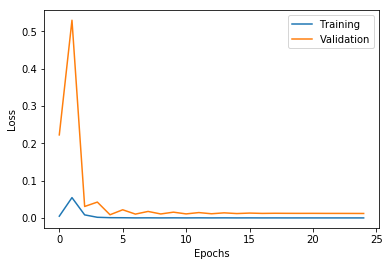

In [8]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

In [9]:
# add one additional data point to align shapes of the predictions and true labels
#X_test = np.append(X_test, scaler.transform(working_data.iloc[-1][0]))
#X_test = np.reshape(X_test, (len(X_test), 1, 1))

# get predictions and then make some transformations to be able to calculate RMSE properly in USD
prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

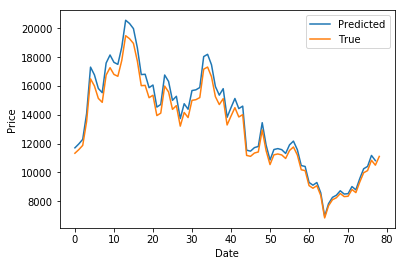

In [10]:
plt.figure()
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(prediction2_inverse)
plt.plot(Y_test2_inverse)
plt.legend(['Predicted', 'True'])